In [1]:
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
from scipy.stats import skew,kurtosis

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
os.chdir('../output_data')

In [6]:
df = pd.read_csv('train_v01.csv',header=0)

In [7]:
df.set_index('PassengerId',inplace=True)

In [8]:
os.chdir('../pickles')

In [9]:
numerical = pickle.load(open('numerical.pickle','rb'))

In [10]:
categorical = pickle.load(open('categorical.pickle','rb'))

In [11]:
os.chdir('../Statistics')

In [12]:
edd_actual = pd.read_csv('edd_v02.csv',header=0)

In [13]:
os.chdir('../Graphs/Box_Plot')

In [14]:
def graph_boxplot_univariate(s2):
    fig=plt.figure()
    plt.boxplot(list(df.loc[df[s2].notnull(),s2]))
    plt.xlabel(s2)
    plt.ylabel('values')
    plt.title('Univariate Ananlysis of '+s2)
    plt.show()
    try:
        fig.savefig(col+'.jpg')
    except:
        pass

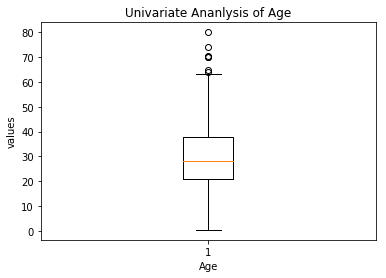

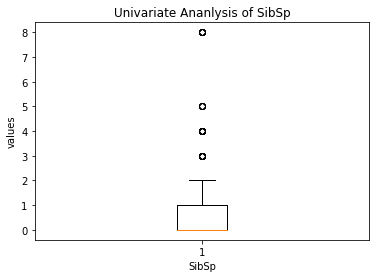

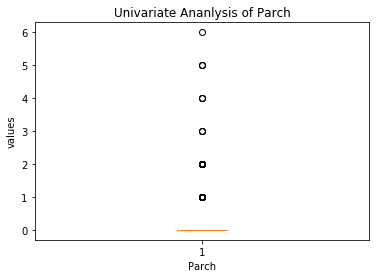

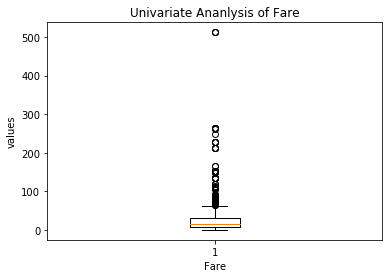

In [15]:
for col in numerical:
    graph_boxplot_univariate(col)

In [16]:
def edd(data):
    df_desc = data.describe().transpose()
    df_desc['Var'] = df_desc.index
    df_desc.reset_index(inplace=True)
    df_desc.drop('count',axis=1,inplace=True)
    df_desc['skewness'] = df_desc['Var'].apply(lambda x: skew(np.array(data.loc[data[x].notnull(),x])))
    df_desc['kurtosis'] = df_desc['Var'].apply(lambda x: kurtosis(np.array(data.loc[data[x].notnull(),x]),fisher=False))
    df_desc['99%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.99))
    df_desc['95%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.95))
    df_desc['90%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.90))
    df_desc['10%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.1))
    df_desc['5%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.05))
    df_desc['1%'] = df_desc['Var'].apply(lambda x: data[x].quantile(.01))
    df_desc['mean-3sigma'] = df_desc['mean'] - 3*df_desc['std']
    df_desc['mean+3sigma'] = df_desc['mean'] + 3*df_desc['std']
    df_desc['mean-2sigma'] = df_desc['mean'] - 2*df_desc['std']
    df_desc['mean+2sigma'] = df_desc['mean'] + 2*df_desc['std']
    df_desc['type']='numeric'
    
    def is_category(col):
        return 'float' not in str(data[col].dtype) and 'int' not in str(data[col].dtype)
    
    categorical = [col for col in data.columns if is_category(col)]
    df_categorical = pd.DataFrame()
    df_categorical['Var']=np.array(categorical)
    
    df_categorical['type']='categorical'
    for col in [c for c in df_desc.columns if c not in ['Var','type']]:
        df_categorical[col]=np.nan
    for col in categorical:
        df_var = data[col].value_counts()
        df_cat = pd.DataFrame()
        df_cat['count']=df_var
        df_cat['categories']=df_var.index
        df_cat.reset_index(inplace=True)
        df_cat.sort_values(by='count',ascending=False,inplace=True)
        df_cat.set_index('categories',inplace=True)
        index_list = df_cat.index.tolist()
        for i,c in enumerate(['mean','min','1%','5%','10%','25%']):
            try:
                df_categorical.loc[df_categorical['Var']==col,c] = index_list[i]
            except:
                break
        for i,c in enumerate(['50%','75%','90%','95%','99%','max']):
            try:
                df_categorical.loc[df_categorical['Var']==col,c] = index_list[-(i+1)]
            except:
                break
        del df_var
        del df_cat
        del index_list
    df_categorical = df_categorical[df_desc.columns]
    edd = pd.concat([df_desc,df_categorical])
    del df_desc
    del df_categorical
    edd['count'] = edd['Var'].apply(lambda x: data[data[x].notnull()].shape[0])
    edd['nmiss'] = data.shape[0]-edd['count']
    edd['missing_rate'] = np.array(edd['nmiss']).astype('float')/data.shape[0] * 100
    edd['unique'] = edd['Var'].apply(lambda x: len(data[x].value_counts().index.tolist()))
    orig_cols = ['mean','min','1%','5%','10%','25%','50%','75%','90%','95%','99%','max']
    new_cols = ['mean_or_top1','min_or_top2','p1_or_top3','p5_or_top4','p10_or_top5','p25_or_top6',
                'p50_or_bottom6','p75_or_bottom5','p90_or_bottom4','p95_or_bottom3','p99_or_bottom2','max_or_bottom1']
    
    convert_dict = {}
    for i in range(len(orig_cols)):
        convert_dict[orig_cols[i]]=new_cols[i]
    edd.rename(columns=convert_dict,inplace=True)
    edd = edd[['Var','type','count','nmiss','missing_rate','unique','std','skewness','kurtosis','mean-3sigma',
               'mean-2sigma','mean_or_top1','min_or_top2','p1_or_top3','p5_or_top4','p10_or_top5','p25_or_top6',
               'p50_or_bottom6','p75_or_bottom5','p90_or_bottom4','p95_or_bottom3','p99_or_bottom2','max_or_bottom1'
              ,'mean+2sigma','mean+3sigma']]
    return edd

In [17]:
edd_transformed = edd(df)

In [18]:
os.chdir('../../Statistics')

In [19]:
edd_transformed.to_csv('edd_transformed.csv',index=False)

In [20]:
def exponential_smoothning(data,s,p1,p5,p95,p99,alpha=.5,high=True,low=True):
    if alpha<=0 or alpha>=1:
        raise ValueError('alpha should be between 0 and 1')
    data.sort_values(s,ascending=True,inplace=True)
    if high==True:
        def get_st_increasing(array,alpha):
            st = array[0]
            i=1
            while i < len(array):
                st = alpha*array[i]+(1-alpha)*st
                i+=1
            return st
        s0 = get_st_increasing(list(np.array(data.loc[(data[s]>=p95) & (data[s]<=p99) & (data[s].notnull()),s])),alpha)
        
        for i in data[(data[s]>p99) & (data[s].notnull())].index.tolist():
            data.loc[i,s] = alpha*data.loc[i,s] + (1-alpha)*s0
            s0 = data.loc[i,s]
            
        if low==True:
            def get_st_decreasing(array,alpha):
                st = array[-1]
                i=len(array)-2
                while i > 0:
                    st = alpha*array[i+1]+(1-alpha)*st
                    i-=1
                return st
            s0 = get_st_decreasing(list(np.array(data.loc[(data[s]>=p1) & (data[s]<=p5) & (data[s].notnull()),s])),alpha)

            for i in data[(data[s]<p1) & (data[s].notnull())].index.tolist()[::-1]:
                data.loc[i,s] = alpha*data[s].loc[i,s] + (1-alpha)*s0
                s0 = data.loc[i,s]

In [21]:
def capping_and_flooring(data,s,a,b,high=True,low=True):
    if high==True:
        data.loc[(data[s]>a) & (data[s].notnull()),s] =a
    if low==True:
        data.loc[(data[s]<b) & (data[s].notnull()),s] = b

In [22]:
def automatic_outlier_treatment(data,s):
    
    lower_limit = data[s].quantile(q=.25)-1.5*(data[s].quantile(q=.75)-data[s].quantile(q=.25))
    upper_limit = data[s].quantile(q=.75)+1.5*(data[s].quantile(q=.75)-data[s].quantile(q=.25))

    frac_lower = float(np.unique(np.array(data[(data[s]<lower_limit) & (data[s].notnull())])).shape[0])/df.shape[0]
    frac_upper = float(np.unique(np.array(data[(data[s]>upper_limit) & (data[s].notnull())])).shape[0])/df.shape[0]

    p1,low_sigma3,low_sigma2 = data[s].quantile(q=.01),data[s].mean()-3*data[s].std(),data[s].mean()-2*data[s].std()
    p99,high_sigma3,high_sigma2 = data[s].quantile(q=.99),data[s].mean()+3*data[s].std(),data[s].mean()+2*data[s].std()
    p5,p95 = data[s].quantile(q=.05),data[s].quantile(q=.95)
    minima,maxima = data[s].min(),data[s].max()

    #deriving lower limit in case of aggresive treatment
    if low_sigma3 >= minima:
        b = min(p1,low_sigma3)
    elif low_sigma2>= minima:
        b = min(p1,low_sigma2)
    else:
        b=p1

    #deriving upper limit in case of aggresive treatment
    if high_sigma3 <= maxima:
        a = max(p99,high_sigma3)
    elif high_sigma2<= maxima:
        a = max(p99,high_sigma2)
    else:
        a=p99

    outlier_treatment = ''

    #lower end outlier treatment
    if frac_lower<=.05:
        capping_and_flooring(data,s,a,b,high=False,low=True)
        if b==p1:
            outlier_treatment+='flooring at p1,'
        elif b==low_sigma2:
            outlier_treatment+='flooring at sigma2,'
        elif b==low_sigma3:
            outlier_treatment+='flooring at sigma3,'
    else:
        try:
            exponential_smoothning(data,s,p1,p5,p95,p99,low=True,high=False)
            outlier_treatment+='lower line exponential smoothing,'
        except:
            pass

    #higher end outlier treatment
    if frac_upper<=.05:
        capping_and_flooring(data,s,a,b,high=True,low=False)
        if b==p1:
            outlier_treatment+='capping at p99'
        elif b==low_sigma2:
            outlier_treatment+='capping at sigma2'
        elif b==low_sigma3:
            outlier_treatment+='Capping at sigma3'
    else:
        try:
            exponential_smoothning(data,s,p1,p5,p95,p99,low=False,high=True)
            outlier_treatment+='higher line exponential smoothing'
        except:
            pass

    return outlier_treatment

In [23]:
edd_actual['outlier_treatment'] = ''
for col in ['Age','Fare']:
    edd_actual.loc[edd_actual['Var']==col,'outlier_treatment']=automatic_outlier_treatment(df,col)

In [24]:
edd_actual['outlier_treatment'].value_counts()

                                                        9
flooring at p1,higher line exponential smoothing        1
flooring at sigma2,higher line exponential smoothing    1
Name: outlier_treatment, dtype: int64

In [25]:
os.chdir('../output_data')

In [26]:
df.to_csv('train_v02.csv')

In [27]:
os.chdir('../Statistics')

In [28]:
edd_actual.to_csv('edd_v03.csv',index=False)

# Imputation

In [29]:
conversion_dict={}

In [30]:
def make_dummies(data,s):
    conversion_list = []
    df_value = pd.DataFrame()
    df_value['counts'] = data[s].value_counts()
    df_value.sort_values(by='counts',ascending=False,inplace=True)
    for category in df_value.index.tolist()[:-1]:
        conversion_list.append(category)
        data[s+'_dum_'+str(category)] = 0
        data.loc[data[s]==category,s+'_dum_'+str(category)]=1
    data.drop(s,axis=1,inplace=True)
    print(s+' done')
    return conversion_list

In [31]:
def make_dummies_binary(data,s):
    df_value=pd.DataFrame()
    df_value['counts']=data[s].value_counts()
    df_value.sort_values(by='counts',ascending=False,inplace=True)
    categories = df_value.index.tolist()
    total_categories = len(categories)
    dummies = len(str(int(bin(total_categories)[2:],10)))
    bin_conv=[]
    for i in range(total_categories):
        bin_conv.append(int(bin(i)[2:],10))
    conv_list=[]
    for i,cat in enumerate(categories):
        conv_list.append((cat,bin_conv[i]))
    for j in range(dummies):
        data[s+'_dum_'+str(j)]=0
        for i,cat in enumerate(categories):
            data.loc[data[s]==cat,s+'_dum_'+str(j)]=bin_conv[i]%10
            bin_conv[i]=bin_conv[i]//10
    data.drop(s,axis=1,inplace=True)
    print(s+' done')
    return conv_list
        

In [33]:
numerical

['Age', 'SibSp', 'Parch', 'Fare']

In [34]:
values={}
for col in categorical:
    values[col]='Unknown'
df.fillna(values,inplace=True)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
PassengerId,,,,,,,,,,,
675,2 class,male,NaN,0,0,Unknown,0.000000,n,S,0,Mr
467,2 class,male,NaN,0,0,Unknown,0.000000,n,S,0,Mr
598,3 class,male,49.00,0,0,LINE,0.000000,n,S,0,Mr
733,2 class,male,NaN,0,0,Unknown,0.000000,n,S,0,Mr
414,2 class,male,NaN,0,0,Unknown,0.000000,n,S,0,Mr
272,3 class,male,25.00,0,0,LINE,0.000000,n,S,1,Mr
303,3 class,male,19.00,0,0,LINE,0.000000,n,S,0,Mr
180,3 class,male,36.00,0,0,LINE,0.000000,n,S,0,Mr
634,1 class,male,NaN,0,0,Unknown,0.000000,n,S,0,Mr


In [35]:
df[categorical].isnull().any()

Pclass      False
Sex         False
Ticket      False
Cabin       False
Embarked    False
Title       False
dtype: bool

In [36]:
for col in categorical:
    if len(df[col].value_counts().index.tolist())<=3:
        conversion_dict[col]=make_dummies(df,col)
    else:
        conversion_dict[col]=make_dummies_binary(df,col)

Pclass done
Sex done
Ticket done
Cabin done
Embarked done
Title done


In [37]:
os.chdir('../pickles')

In [38]:
pickle.dump(conversion_dict,open('conversion_dict.pickle','wb'))

In [39]:
conversion_dict

{'Cabin': [('n', 0),
  ('C', 1),
  ('B', 10),
  ('E', 11),
  ('D', 100),
  ('F', 101),
  ('A', 110),
  ('G', 111),
  ('T', 1000)],
 'Embarked': [('S', 0), ('C', 1), ('Q', 10), ('Unknown', 11)],
 'Pclass': ['3 class', '1 class'],
 'Sex': ['male'],
 'Ticket': [('Unknown', 0),
  ('PC', 1),
  ('CA', 10),
  ('A', 11),
  ('STONO', 100),
  ('SOTONOQ', 101),
  ('SCPARIS', 110),
  ('WC', 111),
  ('C', 1000),
  ('LINE', 1001),
  ('FCC', 1010),
  ('SOC', 1011),
  ('WEP', 1100),
  ('SCParis', 1101),
  ('PPP', 1110),
  ('SOPP', 1111),
  ('PP', 10000),
  ('SWPP', 10001),
  ('FC', 10010),
  ('SC', 10011),
  ('SCAH', 10100),
  ('SCA', 10101),
  ('SOP', 10110),
  ('Fa', 10111),
  ('CASOTON', 11000),
  ('AS', 11001),
  ('SOTONO', 11010),
  ('SCOW', 11011),
  ('SCAHBasle', 11100)],
 'Title': [('Mr', 0),
  ('Miss', 1),
  ('Mrs', 10),
  ('Master', 11),
  ('Dr', 100),
  ('Rev', 101),
  ('Major', 110),
  ('Col', 111),
  ('Mlle', 1000),
  ('Countess', 1001),
  ('Ms', 1010),
  ('Lady', 1011),
  ('Mme', 1100),


In [40]:
imputation_cols = [col for col in df.columns if col not in numerical+['Survived']]

In [41]:
pickle.dump(imputation_cols,open('imputation_cols.pickle','wb'))

In [42]:
os.chdir('../Imputation_models')

In [43]:
for col in ['Age','Fare']:
    data = df[imputation_cols+[col]].dropna(subset=[col])
    x = np.array(data[imputation_cols])
    y = np.array(data[col])
    model = LinearRegression()
    model.fit(x,y)
    del x
    del y
    pickle.dump(model,open(col+'_impute.pickle','wb'))
    if df[col].isnull().any():
        indices = df.loc[df[col].isnull()].index.tolist()
        df.loc[indices,col]=np.array(model.predict(np.array(df.loc[indices,imputation_cols])))
        del indices
    del model
    print(col+' imputed')

Age imputed
Fare imputed


In [44]:
values={}
for col in ['SibSp','Parch']:
    values[col]= 0
df.fillna(values,inplace=True)

,Age,SibSp,Parch,Fare,Survived,Pclass_dum_3 class,Pclass_dum_1 class,Sex_dum_male,Ticket_dum_0,Ticket_dum_1,...,Cabin_dum_1,Cabin_dum_2,Cabin_dum_3,Embarked_dum_0,Embarked_dum_1,Embarked_dum_2,Title_dum_0,Title_dum_1,Title_dum_2,Title_dum_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
675,32.841787,0,0,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
467,32.841787,0,0,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
598,49.000000,0,0,0.000000,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
733,32.841787,0,0,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
414,32.841787,0,0,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
272,25.000000,0,0,0.000000,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
303,19.000000,0,0,0.000000,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
180,36.000000,0,0,0.000000,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
634,41.763188,0,0,0.000000,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df[[x for x in numerical if x!='Survived']].isnull().any()

Age      False
SibSp    False
Parch    False
Fare     False
dtype: bool

In [47]:
os.chdir('../output_data')

In [48]:
df.to_csv('train_v03.csv')

In [49]:
df.isnull().any()

Age                   False
SibSp                 False
Parch                 False
Fare                  False
Survived              False
Pclass_dum_3 class    False
Pclass_dum_1 class    False
Sex_dum_male          False
Ticket_dum_0          False
Ticket_dum_1          False
Ticket_dum_2          False
Ticket_dum_3          False
Ticket_dum_4          False
Cabin_dum_0           False
Cabin_dum_1           False
Cabin_dum_2           False
Cabin_dum_3           False
Embarked_dum_0        False
Embarked_dum_1        False
Embarked_dum_2        False
Title_dum_0           False
Title_dum_1           False
Title_dum_2           False
Title_dum_3           False
dtype: bool